In [ ]:
#@title Mount, Installs and Imports

from google.colab import drive
drive.mount('/content/drive')

!pip --quiet install diffusers
!pip --quiet install accelerate
!pip --quiet install transformers

import os
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import random

import torch
from torchvision import transforms
import torch.nn.functional as F

from diffusers import UNet2DConditionModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers.utils import make_image_grid

from transformers import CLIPTokenizer, CLIPTextModel
from accelerate import Accelerator


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Hyper-parameters

image_size = 128
train_batch_size = 2
vali_batch_size = 1
num_epochs = 6
learning_rate = 1e-4
lr_warmup_steps = 200
output_dir = "/content/drive/My Drive/Deep_Learning/project_305480071_316017763/nb_outputs/osher"

train_type = "all" # "1" for type-1 only (fish), "2" for type-2 only (bird), "3" for type-3 only (snake), "all" for randomly picking from all images
vali_type = "all"  # "1" for type-1 only (fish), "2" for type-2 only (bird), "3" for type-3 only (snake), "all" for randomly picking from all images

to_train = True

In [ ]:
#@title Data Loading

assert train_type in ("1", "2", "3", "all", ), f"Unexpected train_type! Expected \"1\", \"2\", \"3\" or \"all\", got {train_type}"
assert vali_type in ("1", "2", "3", "all", ), f"Unexpected vali_type! Expected \"1\", \"2\", \"3\" or \"all\", got {vali_type}"

with open(f'/content/drive/My Drive/Data/train_data_{train_type}', 'rb') as file:
    train_dataset = pickle.load(file)
with open(f'/content/drive/My Drive/Data/vali_data_{vali_type}', 'rb') as file:
    vali_dataset = pickle.load(file)

In [ ]:
#@title Data Transformation, Data Loaders Declaration and Noise Production/Subtraction

from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [[preprocess(Image.fromarray(datum[0])), datum[1]] for datum in examples]
    return images

train_dataset = transform(train_dataset)
vali_dataset = transform(vali_dataset)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle=True)
vali_dataloader = torch.utils.data.DataLoader(vali_dataset, batch_size = vali_batch_size, shuffle=True)

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps = 1000)
timesteps = torch.LongTensor([50])

def subtract_noise(noise_scheduler, noisy_samples, noise_pred, timesteps):

    alphas_cumprod = noise_scheduler.alphas_cumprod

    sqrt_alpha_prodm1 = alphas_cumprod[timesteps] ** -0.5
    sqrt_alpha_prodm1 = sqrt_alpha_prodm1.flatten().cuda()
    while len(sqrt_alpha_prodm1.shape) < len(noisy_samples.shape):
       sqrt_alpha_prodm1 = sqrt_alpha_prodm1.unsqueeze(-1)

    sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
    sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten().cuda()
    while len(sqrt_one_minus_alpha_prod.shape) < len(noisy_samples.shape):
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

    cleaned_samples = sqrt_alpha_prodm1 * (noisy_samples - sqrt_one_minus_alpha_prod * noise_pred)

    return cleaned_samples

In [ ]:
#@title Model, Optimizer, Loss and Other Network Utilities Definition

model = UNet2DConditionModel(
    sample_size = image_size,
    in_channels = 3,
    out_channels = 3,
    layers_per_block = 2,
    block_out_channels = (128, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "DownBlock2D",
    ),
    mid_block_type='UNetMidBlock2DCrossAttn',
    up_block_types=(
        "UpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "UpBlock2D",
    ),
).to('cuda')

print(sum(p.numel() for p in model.parameters()))

loss = F.mse_loss
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(optimizer = optimizer, num_warmup_steps = lr_warmup_steps, num_training_steps = (len(train_dataloader) * num_epochs))

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.half)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.half).to('cuda')

def get_text_embeds(text):
    with torch.no_grad():
        text_input = tokenizer(text, padding = 'max_length', max_length = tokenizer.model_max_length, truncation = True, return_tensors = 'pt')
        text_embeds = text_encoder(text_input.input_ids.to('cuda'))[0]

    return text_embeds

144055299


  0%|          | 0/2600 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

a photography of a snake laying on the ground next to rocks


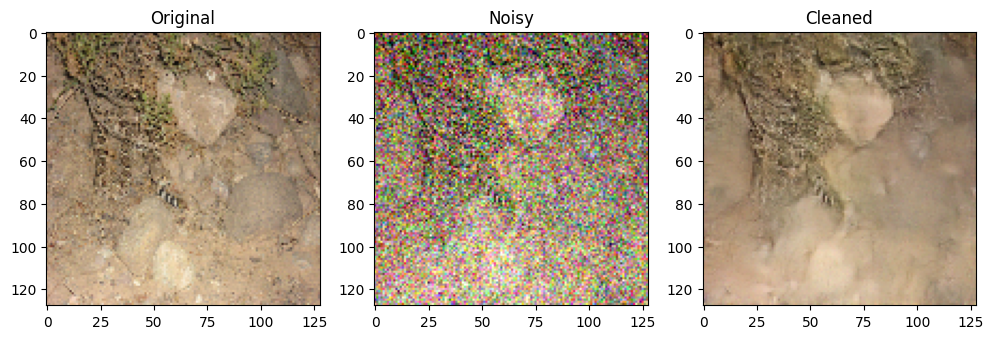

a photography of a black and white bird sitting on a branch


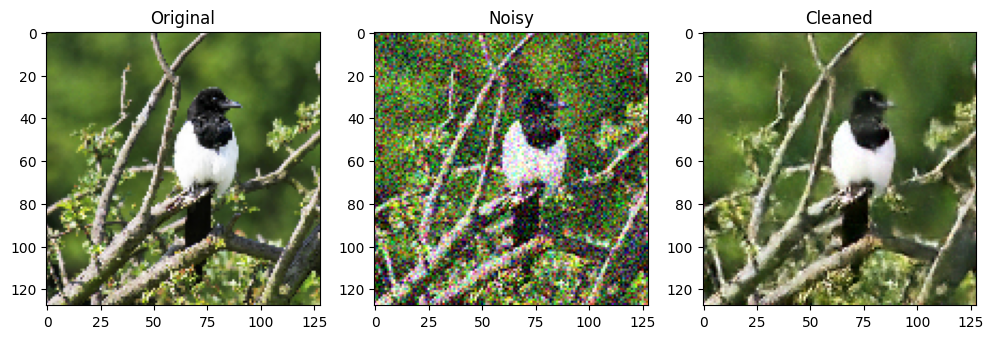

a photography of a bird sitting on a branch in the wild


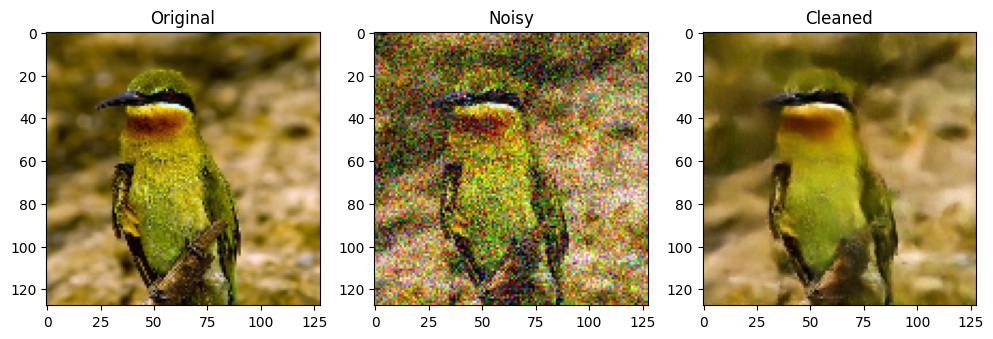

a photography of a snake laying on the ground next to a bush


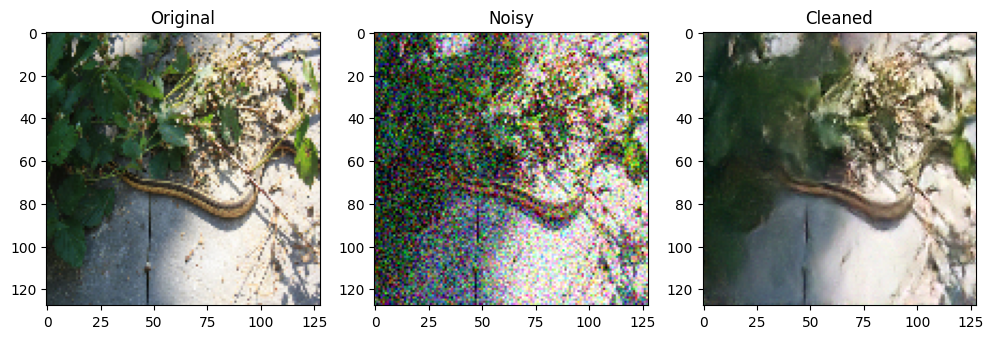

s


  0%|          | 0/2600 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
#@title Training Process
if to_train:
    accelerator = Accelerator(mixed_precision = "fp16", gradient_accumulation_steps = 1, log_with = "tensorboard", project_dir = os.path.join(output_dir, "logs"))
    if accelerator.is_main_process:
        os.makedirs(output_dir, exist_ok = True)
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

    global_step = 0
    loss_train_full = []
    loss_vali_full = []

    for epoch in range(num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0]
            texts = batch[1]
            embeds = []
            for text in texts:
                embeds.append(get_text_embeds(text))

            embeds = torch.cat((torch.stack(embeds).squeeze(1), torch.zeros((train_batch_size, 77, 512)).to('cuda')), dim=2)
            noise = torch.randn(clean_images.shape).to("cuda")

            timesteps = torch.LongTensor([120]).to('cuda')

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                with torch.autocast('cuda'):
                    noise_pred = model(noisy_images, timesteps, embeds, return_dict = False)[0]
                    loss_now = loss(noise_pred, noise)
                    accelerator.backward(loss_now)
                    loss_train_full.append(loss_now.detach().cpu().numpy())
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    lr_scheduler.step()
                    optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss_now.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)
            #accelerator.log(logs, step = global_step)
            global_step += 1

        loss_this_vali = []
        idx_to_plot = []
        for i in range(4):
            idx_to_plot.append(random.randint(0, len(vali_dataloader) - 1))
        for idx, batch in tqdm(enumerate(vali_dataloader), total = len(vali_dataloader)):
            with torch.no_grad():
                with torch.autocast('cuda'):
                    clean_images = batch[0]
                    texts = batch[1]
                    embeds = []
                    for text in texts:
                        embeds.append(get_text_embeds(text))

                    embeds = torch.cat((torch.stack(embeds).squeeze(1), torch.zeros((1, 77, 512)).to('cuda')), dim=2)

                    noise = torch.randn(clean_images.shape).to("cuda")

                    timesteps = torch.LongTensor([120]).to('cuda')

                    noisy_images = noise_scheduler.add_noise(clean_images.to('cuda'), noise.to('cuda'), timesteps.to('cuda'))
                    noise_pred = model(noisy_images, timesteps, embeds, return_dict = False)[0]

                    loss_this_vali.append(loss(noise_pred, noise))

                    if idx in idx_to_plot:
                        cleaned_images = subtract_noise(noise_scheduler, noisy_images.cuda(), noise_pred.cuda(), timesteps.cpu())
                        print(text)
                        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                        axs[0].set_title('Original')
                        axs[1].set_title('Noisy')
                        axs[2].set_title('Cleaned')
                        axs[0].imshow(clean_images[0,:,:,:].permute((1, 2, 0)).detach().cpu().numpy() * 0.5 + 0.5)
                        axs[1].imshow(noisy_images[0,:,:,:].permute((1, 2, 0)).detach().cpu().numpy() * 0.5 + 0.5)
                        axs[2].imshow(cleaned_images[0,:,:,:].permute((1, 2, 0)).detach().cpu().numpy() * 0.5 + 0.5)

                        plt.savefig(os.path.join(output_dir, f'train_{train_type}_vali_{vali_type}_epoch_{epoch+1}_example_{idx}.png'))
                        plt.show()

        loss_vali_current = torch.mean(torch.Tensor(loss_this_vali)).detach().cpu().numpy()
        loss_vali_full.append(loss_vali_current)

        #torch.save(model.state_dict(), os.path.join(output_dir, f'MODEL_train{train_type}_epochs{epoch + 1}'))
        print('s')


In [ ]:
if to_train:
    plt.plot(loss_train_full)
    plt.grid()
    plt.title('Loss vs Batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.savefig(os.path.join(output_dir, f'Loss_vs_Batch_Model_train_{train_type}.jpg'))
    plt.show()

    plt.plot(np.arange(6) + 1, loss_vali_full)
    plt.grid()
    plt.title('Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(os.path.join(output_dir, f'Loss_vs_Epoch_Model_train_{train_type}.jpg'))
    plt.show()

    with open(os.path.join(output_dir, f'full_loss_train_{train_type}'), 'wb') as file:
        pickle.dump(loss_vali_full, file)
    with open(os.path.join(output_dir, f'full_loss_vali_{train_type}'), 'wb') as file:
        pickle.dump(loss_train_full, file)

In [ ]:
#@title Inference (on all 5 models)

from diffusers import UNet2DModel
from sklearn.metrics import mean_squared_error

conditional_model_path = output_dir
conditional_model_names = ('train1/MODEL_train1', 'train2/MODEL_train2', 'train3/MODEL_train3', 'trainall/MODEL_trainall', )
uncond_model_name = 'unet/MODEL_unet'

data_path = '/content/drive/My Drive/Data'
test_file_names = ('vali_data_1', 'vali_data_2', 'vali_data_3', 'vali_data_all', )

final_PSNR_lists = []
final_loss_lists = []

for c_name in conditional_model_names:
    model.load_state_dict(torch.load(os.path.join(conditional_model_path, c_name)))
    model.eval()

    PSNR_mean_this_model = []
    loss_this_model = []

    for t_name in test_file_names:
        with open(os.path.join(data_path, t_name), 'rb') as file:
            test_dataset = pickle.load(file)

        test_dataset = transform(test_dataset)

        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle=True)

        loss_this_test = []
        PSNRs = []

        for idx, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
            with torch.no_grad():
                with torch.autocast('cuda'):
                    clean_images = batch[0]
                    texts = batch[1]
                    embeds = []
                    for text in texts:
                        embeds.append(get_text_embeds(text))

                    embeds = torch.cat((torch.stack(embeds).squeeze(1), torch.zeros((1, 77, 512)).to('cuda')), dim=2)
                    noise = torch.randn(clean_images.shape).to("cuda")

                    timesteps = torch.LongTensor([120]).to('cuda')

                    noisy_images = noise_scheduler.add_noise(clean_images.to('cuda'), noise.to('cuda'), timesteps.to('cuda'))
                    noise_pred = model(noisy_images, timesteps, embeds, return_dict = False)[0]

                    cleaned_images = subtract_noise(noise_scheduler, noisy_images, noise_pred, timesteps.cpu()).detach().cpu().numpy()
                    cleaned_images = np.uint8(np.clip(cleaned_images * 0.5 + 0.5, 0.0, 1.0) * 255.0)
                    clean_images.detach().cpu().numpy()
                    clean_images = np.uint8(np.clip(clean_images * 0.5 + 0.5, 0.0, 1.0) * 255.0)

                    MSE = mse = ((clean_images - cleaned_images)**2).mean()
                    PSNR_curr = float(20 * np.log10(255.0) - 10 * np.log10(MSE))
                    PSNRs.append(PSNR_curr)

                    loss_this_test.append(loss(noise_pred, noise))
        PSNR_mean_this_model.append(np.mean(PSNRs))
        loss_this_model.append(torch.mean(torch.Tensor(loss_this_test)).detach().cpu().numpy())

    final_PSNR_lists.append(PSNR_mean_this_model)
    final_loss_lists.append(loss_this_model)

print(np.array(final_PSNR_lists))

model = UNet2DModel(
    sample_size = image_size,
    in_channels = 3,
    out_channels = 3,
    layers_per_block = 2,
    block_out_channels = (128, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
).to('cuda')

model.load_state_dict(torch.load(os.path.join(conditional_model_path, uncond_model_name)))
model.eval()

loss_this_model = []
PSNR_mean_this_model = []

for t_name in test_file_names:
    with open(os.path.join(data_path, t_name), 'rb') as file:
        test_dataset = pickle.load(file)

    test_dataset = transform(test_dataset)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle=True)
    loss_this_test = []
    PSNRs = []

    for idx, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
        with torch.no_grad():
            with torch.autocast('cuda'):
                clean_images = batch[0]
                noise = torch.randn(clean_images.shape).to("cuda")
                timesteps = torch.LongTensor([120]).to('cuda')
                noisy_images = noise_scheduler.add_noise(clean_images.to('cuda'), noise.to('cuda'), timesteps.to('cuda'))
                noise_pred = model(noisy_images, timesteps, return_dict = False)[0]
                cleaned_images = subtract_noise(noise_scheduler, noisy_images, noise_pred, timesteps.cpu()).detach().cpu().numpy()
                cleaned_images = np.uint8(np.clip(cleaned_images * 0.5 + 0.5, 0.0, 1.0) * 255.0)
                clean_images.detach().cpu().numpy()
                clean_images = np.uint8(np.clip(clean_images * 0.5 + 0.5, 0.0, 1.0) * 255.0)

                MSE = mse = ((clean_images - cleaned_images)**2).mean()
                PSNR_curr = float(20 * np.log10(255.0) - 10 * np.log10(MSE))
                PSNRs.append(PSNR_curr)
                loss_this_test.append(loss(noise_pred, noise))

    loss_this_model.append(torch.mean(torch.Tensor(loss_this_test)).detach().cpu().numpy())
    PSNR_mean_this_model.append(np.mean(PSNRs))

print(np.array(PSNR_mean_this_model))